<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/NY_clusteringCountyData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [93]:
import pandas as pd
import wget 
from PIL import Image

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture

# Load Data

In [4]:
NY_labeled_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/NY_labeledData_Sep26.csv',low_memory=False)
NY_labeled_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label,New Cases/1k population,growth_label_1k,growth_1k_pop
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0,0.0,305506.0,LessSpread,flat_growth,0.0,flat_growth,0.0
1,2020-03-01,36123,Yates County,31.0,33.0,0.0,0.0,7.0,0.0,28.14,5.004,72,73.676584,0,0.0,0,0.0,24913.0,LessSpread,flat_growth,0.0,flat_growth,0.0
2,2020-03-01,36021,Columbia County,21.0,4.0,0.0,25.0,4.0,0.0,19.75,5.337,58,93.682154,0,0.0,0,0.0,59461.0,LessSpread,flat_growth,0.0,flat_growth,0.0
3,2020-03-01,36095,Schoharie County,26.0,9.0,0.0,0.0,13.0,0.0,24.47,2.137,27,49.852047,0,0.0,0,0.0,30999.0,LessSpread,flat_growth,0.0,flat_growth,0.0
4,2020-03-01,36033,Franklin County,28.0,27.0,0.0,0.0,7.0,0.0,10.82,2.205,56,30.704920,0,0.0,0,0.0,50022.0,LessSpread,flat_growth,0.0,flat_growth,0.0


In [6]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=d84129fc41a2472e3f6a45d8cce331cdf15b24a7a2295d4ea72c7e1cd537b2ee
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [9]:
US_population_filename = wget.download('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_county_population_usafacts.csv')
county_population_US = pd.read_csv(US_population_filename,low_memory=False)
print(county_population_US.shape)

county_population_US.head(2)

(3195, 4)


,countyFIPS,County Name,State,population
0,0,Statewide Unallocated,AL,0
1,1001,Autauga County,AL,55869


In [10]:
county_population_US.State.unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

## Preprocess data

In [12]:
NY_labeled_data["label"] = NY_labeled_data["label"].astype('category')
NY_labeled_data['spread_category']= NY_labeled_data["label"].cat.codes

In [32]:
print(NY_labeled_data.shape)
NY_labeled_data[pd.isna(NY_labeled_data["label"])].shape

(9804, 24)


(14, 24)

In [33]:
NY_labeled_data_filtered = NY_labeled_data.dropna()

In [41]:
NY_labeled_data_filtered[['spread_category','label']]
#NY_labeled_data_filtered['label'].unique()

,spread_category,label
0,0,LessSpread
1,0,LessSpread
2,0,LessSpread
3,0,LessSpread
4,0,LessSpread
...,...,...
9799,0,LessSpread
9800,0,LessSpread
9801,0,LessSpread
9802,0,LessSpread


## Check each class data

In [35]:
X_cols = ['retail and recreation',
       'grocery and pharmacy', 'parks', 'transit stations', 'workplaces',
       'residential', 'driving', 'm50', 'm50_index', 'population_density',
       'mask_rule_active', 'mask_wearing_percent', 'New cases',
       'rolling_avg_new_cases']

Y_col = ['spread_category']


In [36]:
NY_labeled_data[Y_col]

,spread_category
0,0
1,0
2,0
3,0
4,0
...,...
9799,0
9800,0
9801,0
9802,0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


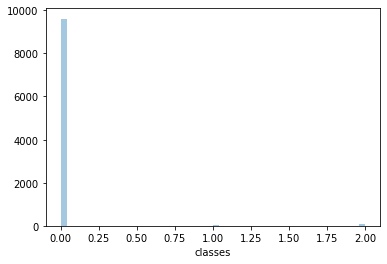

In [47]:
training_outputs_labels = [c for row in NY_labeled_data_filtered[Y_col].values for c in row]
sns.distplot(pd.Series(training_outputs_labels, name="classes"), kde=False)


**Note**

From the above plot we have more less spread labels compared to 'spread' and 'super spread' data

## Multiclass Classification without a Classifier!

In [48]:
n_classes = 3
training_inputs = NY_labeled_data_filtered[X_cols].values
training_outputs_labels = [c for row in NY_labeled_data_filtered[Y_col].values for c in row]


In [49]:
clusters = {this_class:[training_inputs[i] for i,c in enumerate(training_outputs_labels) if c == this_class] for this_class in range(n_classes)}
centroids = [np.mean(np.array(vectors), axis=0) for vectors in clusters.values()]

In [60]:
centroids[0]


array([-1.62138843e+01,  3.63134888e+00,  1.83134888e+01, -1.16838052e+01,
       -2.93359700e+01,  8.09793922e+00,  4.00239790e+01,  3.50279038e+00,
        5.34115321e+01,  1.52287836e+03,  7.51977519e-01,  5.82340758e-01,
        3.94205870e+01,  4.09047223e+01])

In [50]:
def plot_class_centroid(c):
  class_vectors = list(clusters.values())[c]
  class_label_vector = centroids[c]
  
  X = [x for x,_ in class_vectors + [class_label_vector]]
  Y = [y for _,y in class_vectors + [class_label_vector]]
  colours = ([c] * (len(X) - 1)) + [c+1]
  sizes = ([10] * (len(X) - 1)) + [len(X)]

  plt.scatter(X, Y, s = sizes, c= colours, alpha=0.5)

In [65]:
class_vectors = list(clusters.values())[0]
class_label_vector = centroids[0]
#print(class_label_vector)
#print(class_vectors)
#X = [x for x,_ in class_vectors + [class_label_vector]]


In [66]:
from scipy.spatial.distance import cosine

def predict_class(vector, class_vectors):
  scores = [(cosine(vector, class_vector),c) for c,class_vector in enumerate(class_vectors)]
  ranked = [c for _,c in sorted(scores)]
  return ranked[0]

In [73]:
NY_labeled_data_filtered[X_cols].values[0]

array([ 10.        ,  13.        ,  19.        ,   4.        ,
         7.        ,  -1.        ,  -4.87      ,   2.616     ,
        54.        , 584.36495792,   0.        ,   0.        ,
         0.        ,   0.        ])

In [76]:
predict_class(NY_labeled_data_filtered[X_cols].values[299], centroids)

0

## Evaluate metrics

In [87]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(y,y_hat,labels):
  print(classification_report(y,y_hat))
  cm = confusion_matrix(y,y_hat)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmat = pd.DataFrame(cm)
  cmat.columns = labels
  #cmat.set_index([pd.Index(labels, '')],inplace=True)
  sns.heatmap(cmat,cmap="YlGnBu", annot=True)
  plt.title("Confusion Matrix")

In [84]:
training_outputs_labels = [c for row in NY_labeled_data_filtered[Y_col].values for c in row]
labels = set(training_outputs_labels)
labels

{0, 1, 2}

[0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 

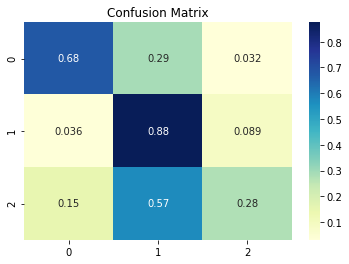

In [122]:
centroid_predictions_labels = [predict_class(xy, centroids) for xy in NY_labeled_data_filtered[X_cols].values]
print(centroid_predictions_labels)
print(training_outputs_labels)
evaluate(training_outputs_labels, centroid_predictions_labels, labels)



In [137]:
def one_hot(i, vec_len):
  vector = [0]*vec_len
  vector[i] = 1
  return vector

def format_prediction(predicted_outputs):
  predicted_image_array = np.zeros_like(image_array)
  i = 1
  for row,pixels in enumerate(predicted_image_array):
    for column in range(len(pixels)):
      #print(i)
      #if i >= y: print('breaking ',i); break

      p = np.argmax(predicted_outputs[i-1])
      predicted_image_array[row][column] = [WHITE,RED,BLUE][p]
      i += 1
    #break
  return predicted_image_array

In [112]:
RED = [255,0,0]
WHITE = [255,255,255]
BLUE = [0,0,255]

x,y = NY_labeled_data_filtered.shape
z = 3 # number of classes 
x,y,z

(9762, 24, 3)

In [99]:
image_array = np.zeros((x,y,z), np.uint8)


In [139]:
plot_class_centroid(0)
centroids[0]

ValueError: ignored

In [140]:

centroid_predictions = [one_hot(p, z) for p in centroid_predictions_labels]
#Image.fromarray(format_prediction(centroid_predictions)) 
centroid_predictions

[[1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [0, 0, 1],
 [1, 0, 0],
 [0, 0, 1],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [0, 0, 1],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [0, 0, 1],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [0, 0, 1],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [0, 0, 1],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1,